In [1]:
import torch as pt
import torch.nn as nn
from torch.utils.data import random_split
from src.dataset import MolDataset
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score, cohen_kappa_score
import sys

/home/dima/miniconda3/envs/ctpesto/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format =   'svg'

In [3]:
pt.manual_seed(1158)
device = "cuda" if pt.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Dataset and Net

In [5]:
N = 18000
dataset = MolDataset("../data/preprocessed/X.pk.zip", 
                     y_datafile="../data/preprocessed/Y.pk.zip", normal = True)
train_dataset, test_dataset = random_split(dataset, [len(dataset) - N, N])

In [6]:
len(train_dataset)

52711

In [8]:
dataset[33][0].shape

(214,)

In [9]:
print(len(dataset)/np.sum(dataset[:][1], axis=0))

0.5257127987807144


In [10]:
np.sum(test_dataset[:][1] ==1)

752

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(214, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
                        nn.ReLU(),
            nn.Linear(128, 128),
                        nn.ReLU(),
            nn.Linear(128, 128),
                        nn.ReLU(),
            nn.Linear(128, 128),
                        nn.ReLU(),
            nn.Linear(128, 128),
                        nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

    

In [12]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=214, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=3, bias=True)
  )
)


#  Train

## Example

In [14]:
# X.shape

In [15]:
ids = [8,2100,11111, 3674,9867]

X1 = train_dataset[ids][0]
X = pt.tensor(X1, device=device)
treu_y = dataset[ids][1]

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")
# print(f"True classes: {treu_y}")

In [16]:
pred_probab

tensor([[0.3255, 0.3372, 0.3373],
        [0.3255, 0.3372, 0.3373],
        [0.3255, 0.3372, 0.3373],
        [0.3255, 0.3372, 0.3373],
        [0.3255, 0.3372, 0.3373]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [17]:
pred_probab.argmax(1)

tensor([2, 2, 2, 2, 2], device='cuda:0')

In [18]:
treu_y

array([0, 1, 2, 2, 2])

## Parameters of training

In [19]:
# loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
class_weights = pt.Tensor([1, 1, 0.05])
class_weights.to(device)
# weight=class_weights,reduction='mean'
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = pt.optim.Adam(model.parameters())

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, ycls,  Y) in enumerate(dataloader):
        # Compute prediction and loss
        x = X.to(device)
        pred = model(x) 
        # p = pt.squeeze(pred, dim=1)
        yyy = pt.Tensor(ycls).type(pt.LongTensor).to(device)
        loss = loss_fn(pred, yyy)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # print(f"score {score}")



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    score = 0
    with pt.no_grad():
        for X, ycls, Y in dataloader:
            x = X.to(device)
            pred = model(x) 
            yyy = pt.Tensor(ycls).type(pt.LongTensor).to(device)
            # loss = loss_fn(p, yyy)
            test_loss += loss_fn(pred, yyy)
            
                        #convert to classes
            pred_probab = nn.Softmax(dim=1)(pred)
            pred_cats = np.array(pred_probab.argmax(1).cpu())  
            # # score = f1_score(pred_cats, ycls, average=None)
            # score = cohen_kappa_score(pred_cats, ycls)
            ts = f1_score(pred_cats, ycls, average=None)
            ts2 = cohen_kappa_score(pred_cats, ycls)
            # # print(ts.shape)
            score += ts2


    test_loss /= num_batches
    #     correct /= size
    #     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss:>8f} score: {score/52.}\n")
    return(score/52.)


In [21]:
epochs = 45
# train model
train_dataloader = DataLoader(train_dataset, batch_size=1024,
                              shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024,
                             shuffle=True, pin_memory=True)
scores = []
for t in range(epochs):
    sys.stdout.write(f"{t} ") 
    print(f"Epoch {t + 1}\n-------------------------------")
    # logger.store_progress(0, is_train=True, epoch=t+1)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    s = test_loop(test_dataloader, model, loss_fn)
    scores.append(s)
print("Done!")

0 Epoch 1
-------------------------------
loss: 1.087585  [    0/52711]
loss: 0.445875  [25600/52711]
loss: 0.295412  [51200/52711]
Avg loss: 0.299533 score: 0.0

1 Epoch 2
-------------------------------
loss: 0.273467  [    0/52711]
loss: 0.292300  [25600/52711]
loss: 0.292935  [51200/52711]
Avg loss: 0.300277 score: 0.0

2 Epoch 3
-------------------------------
loss: 0.343843  [    0/52711]
loss: 0.315222  [25600/52711]
loss: 0.285950  [51200/52711]
Avg loss: 0.298878 score: 0.0

3 Epoch 4
-------------------------------
loss: 0.283204  [    0/52711]
loss: 0.266328  [25600/52711]
loss: 0.315371  [51200/52711]
Avg loss: 0.299677 score: 0.0

4 Epoch 5
-------------------------------
loss: 0.273258  [    0/52711]
loss: 0.314716  [25600/52711]
loss: 0.298442  [51200/52711]
Avg loss: 0.299878 score: 0.0

5 Epoch 6
-------------------------------
loss: 0.276482  [    0/52711]
loss: 0.312640  [25600/52711]
loss: 0.331987  [51200/52711]
Avg loss: 0.299437 score: 0.0

6 Epoch 7
------------

(-1e-05, 0.1)

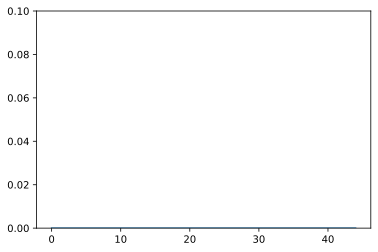

In [22]:
plt.plot(scores)
plt.ylim([-0.00001,0.1])

In [ ]:
pt.save(model.state_dict(), "model.pt")

In [24]:
with pt.no_grad():
    for X, ycls, Y in train_dataloader:
        x = X.to(device)
        y = Y[:,None,:].to(device)

In [25]:
logits = model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

In [26]:
x.shape

torch.Size([487, 214])

In [30]:
logits[0:18]

tensor([[-1.3393, -0.9461,  2.2215],
        [-1.2403, -0.8767,  2.0450],
        [-1.2739, -0.9002,  2.1049],
        [-1.3696, -0.9673,  2.2755],
        [-1.2562, -0.8878,  2.0734],
        [-1.3631, -0.9628,  2.2640],
        [-1.3253, -0.9363,  2.1966],
        [-1.2951, -0.9151,  2.1427],
        [-1.2722, -0.8990,  2.1019],
        [-1.2884, -0.9104,  2.1308],
        [-1.3639, -0.9634,  2.2654],
        [-1.3156, -0.9295,  2.1794],
        [-1.3907, -0.9821,  2.3131],
        [-1.2607, -0.8910,  2.0814],
        [-1.3877, -0.9800,  2.3078],
        [-1.2309, -0.8701,  2.0283],
        [-1.2879, -0.9101,  2.1300],
        [-1.3314, -0.9406,  2.2075]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [29]:
y[0:18,:,:]

tensor([[[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]]], device='cuda:0', dtype=torch.float64)